In [1]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 30  #  dBm
jam_power_dbm = 50
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

In [2]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np


# Generate RX positions

distances_km = [0.0001]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

sat_orbit_m = 550e3
# angles = [(120, 80),(45, 90), (75,75),(80,88), (65, 85),(130,75)]
angles = [(45, 90), (120, 80), (75,75),(80,88), (65, 85),(130,75)]
# angles = [(45, 90), (120, 80), (75,75)]
sat_positions = []
delays_ms = []
fspl_db = []
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

sat_positions = np.array(sat_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("\nSatellite Pos [m]:\n", sat_positions)
# print("\nPropagation delays [ms]:\n", delays_ms)
# print("\nFree-space path loss [dB]:\n", fspl_db)


# Compute az/el/dist per TX-SAT
  
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


TX0(m): [0. 0. 0.]
TX1(m): [ 6.12323400e-18  1.00000000e-01 -7.07323089e-10]

Satellite Pos [m]:
 [[ 2.38137915e-11  2.38137915e-11  5.50000000e+05]
 [ 8.38834990e+04 -4.84301607e+04  5.49322180e+05]
 [ 1.41946635e+05  3.80344862e+04  5.48439683e+05]
 [ 1.89137181e+04  3.33499880e+03  5.49973353e+05]
 [ 4.35971558e+04  2.03296876e+04  5.49832825e+05]
 [ 1.12573272e+05 -9.44601913e+04  5.48439683e+05]]

From TX0:
  SAT0: az=45.00°, el=90.00°, dist=550000.00 m, λ count ≈ 18333333.33
  SAT1: az=120.00°, el=80.00°, dist=557796.36 m, λ count ≈ 18593212.01
  SAT2: az=75.00°, el=75.00°, dist=567786.54 m, λ count ≈ 18926218.02
  SAT3: az=80.00°, el=88.00°, dist=550308.59 m, λ count ≈ 18343619.53
  SAT4: az=65.00°, el=85.00°, dist=551933.10 m, λ count ≈ 18397769.90
  SAT5: az=130.00°, el=75.00°, dist=567786.54 m, λ count ≈ 18926218.02

From TX1:
  SAT0: az=180.00°, el=90.00°, dist=550000.00 m, λ count ≈ 18333333.33
  SAT1: az=120.00°, el=80.00°, dist=557796.37 m, λ count ≈ 18593212.30
  SAT2: a

In [3]:
from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver
import numpy as np

def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = Scene()
    scene.frequency = frequency
    scene.synthetic_array = True

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)

    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at)
        rx_list.append(rx)

    tx.look_at(tx_look_at)  # Point TX to the first RX

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                   seed=41)

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all


In [4]:
jam_rows = 8
jam_cols = 8
jam_antennas = jam_cols*jam_rows

sat_rows = 1
sat_cols = 1
sat_antennas = sat_cols*sat_rows

tx_rows = 8
tx_cols = 8
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                        #  pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")




In [5]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 30  #  dBm
jam_power_dbm = 30
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

In [6]:

def single_beamforming(h):
    return h.conj() / np.linalg.norm(h)


CP_tx_list = []
CP_tx_jam_list = []
w_tx_list = []
w_jam_list = []
h_tx_list = []
h_jam_list = []

for i, pos in enumerate(sat_positions):

    a_tx, tau_tx = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array, sat_positions[i], gnd_positions[0])
    a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array, sat_positions[i], gnd_positions[0])
    

    h_tx = a_tx[i, :, 0, :, 0, 0].T.squeeze()
    h_jam = a_jam[i, :, 0, :, 0, 0].T.squeeze()


    w_tx = single_beamforming(h_tx)
    w_jam = single_beamforming(h_jam)

    CG_tx = np.abs(h_tx.conj().T @ w_tx)**2
    CG_jam = np.abs(h_jam.conj().T @ w_jam)**2
    CP_tx = np.log2(1+Tx_power_watt*CG_tx/noise_power_watt)
    CP_tx_jam = np.log2(1+Tx_power_watt*CG_tx/(jam_power_watt*CG_jam+noise_power_watt))
    

    CP_tx_list.append(CP_tx)
    CP_tx_jam_list.append(CP_tx_jam)
    w_tx_list.append(w_tx)
    w_jam_list.append(w_jam)
    h_tx_list.append(h_tx)
    h_jam_list.append(h_jam)

CP_tx      = np.array(CP_tx_list).reshape(-1, 1)             # shape: (N,1)
CP_tx_jam  = np.array(CP_tx_jam_list).reshape(-1, 1)        # shape: (N,1)
w_tx_all = np.stack(w_tx_list, axis=0)    # shape: (N, N_tx)
h_tx_all = np.stack(h_tx_list, axis=0)    # shape: (N, N_tx)
h_jam_all = np.stack(h_jam_list, axis=0)  # shape: (N, N_tx)

N = CP_tx.shape[0]
M = np.tile(CP_tx, (1, N))
np.fill_diagonal(M, CP_tx_jam.flatten())

print( M)



[[0.30398743 2.40828046 2.40828046 2.40828046 2.40828046 2.40828046]
 [5.11990217 0.97910572 5.11990217 5.11990217 5.11990217 5.11990217]
 [5.07017689 5.07017689 0.97836677 5.07017689 5.07017689 5.07017689]
 [5.15778917 5.15778917 5.15778917 0.97965046 5.15778917 5.15778917]
 [5.14952301 5.14952301 5.14952301 5.14952301 0.97953258 5.14952301]
 [5.07017807 5.07017807 5.07017807 5.07017807 5.07017807 0.97836702]]


In [7]:


def generate_probabilities(CP_tx, mode="uniform"):

    N = CP_tx.shape[0]

    if mode == "uniform":
        p = np.full((N, 1), 1.0 / N)

    elif mode == "proportional":
        flat = CP_tx.flatten()
        total = np.sum(flat)
        if total == 0:
            raise ValueError("Sum of CP_tx is zero; cannot normalize.")
        p = (flat / total).reshape(-1, 1)

    else:
        raise ValueError("Unsupported mode. Use 'uniform' or 'proportional'.")

    return p

def optimal_jammer_q(p, M):
    """
    Find the optimal jammer strategy q that minimizes the expected capacity:
        minimize    p.T @ M @ q
        subject to  q is a valid probability vector

    Since the objective is linear in q, the optimal q is one-hot (pure strategy).

    Parameters
    ----------
    p : (N, 1) ndarray
        Probability distribution over the channel states (e.g., from user side).
    M : (N, N) ndarray
        Capacity matrix. Each column corresponds to one jammer strategy.

    Returns
    -------
    q_opt : (N, 1) ndarray
        Optimal jammer probability vector (one-hot vector).
    C_min : float
        The minimal achievable expected capacity.
    """
    pm = p.T @ M                     # shape: (1, N)
    scores = pm.flatten()           # shape: (N,) for argmin
    j_star = int(np.argmin(scores)) # index with the lowest expected capacity

    q_opt = np.zeros_like(p)        # initialize one-hot vector
    q_opt[j_star, 0] = 1.0          # set 1 at the best column

    C_min = scores[j_star]          # minimal expected capacity

    return q_opt, C_min, pm


In [8]:
p = generate_probabilities(CP_tx, mode="proportional")
print("probs:\n", p)

q_opt, C_min, pm = optimal_jammer_q(p, M)

print("p^T @ M ") 
print(pm)

print("\nOptimal jammer distribution (one-shot):")
print(q_opt)

print("\nMinimal achievable average capacity pᵀMq:")
print(C_min)



probs:
 [[0.08608426]
 [0.1830115 ]
 [0.18123406]
 [0.18436577]
 [0.1840703 ]
 [0.1812341 ]]
p^T @ M 
[[4.69974145 4.12307461 4.1393126  4.1105822  4.11331659 4.13931226]]

Optimal jammer distribution (one-shot):
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]

Minimal achievable average capacity pᵀMq:
4.110582200089811


In [ ]:
import numpy as np
import cvxpy as cp

def compute_beamforming_vector(H, mode="eig1"):
    """
    Compute the transmit beamforming vector using one of:
    - 'eig1': Eigen-decomposition on unweighted Q
    - 'eig2': Eigen-decomposition on weighted Q (equalizes TX energy per direction)
    - 'avg' : Normalized average of effective channels

    Parameters:
        H: numpy array of shape (N_rx, rx_antennas, N_tx, tx_antennas)
        mode: 'eig1', 'eig2', 'avg', or 'fair'

    Returns:
        w: Normalized beamforming vector of shape (tx_antennas, 1)
        norm_last_h_eff: Norm of last h_eff computed (debug/info)
    """
    N_rx, rx_antennas, N_tx, tx_antennas = H[..., 0, 0].shape
    assert N_tx == 1, "Only supports single TX (N_tx == 1)"

    w_r = np.ones((rx_antennas, 1), dtype=complex) / np.sqrt(rx_antennas)

    if mode in ("eig1", "eig2"):
        Q = np.zeros((tx_antennas, tx_antennas), dtype=complex)
        for rx in range(N_rx):
            H_rx = H[rx, :, 0, :,0,0]           # (rx_antennas, tx_antennas)
            h_eff = H_rx.conj().T @ w_r     # (tx_antennas, 1)
            alpha = 1.0 / np.linalg.norm(h_eff)**2 if mode == "eig2" else 1.0
            Q += alpha * (h_eff @ h_eff.conj().T)
        eigvals, eigvecs = np.linalg.eigh(Q)
        w = eigvecs[:, -1]
    elif mode == "none":
        w = np.ones((tx_antennas, 1)) / np.sqrt(tx_antennas)
        for rx in range(N_rx):
            H_rx = H[rx, :, 0, :,0,0]           # (rx_antennas, tx_antennas)
            h_eff = H_rx.conj().T @ w_r     # (tx_antennas, 1)
    elif mode == "avg":
        w_sum = np.zeros((tx_antennas, 1), dtype=complex)
        for rx in range(N_rx):
            H_rx = H[rx, :, 0, :,0,0]
            h_eff = H_rx.conj().T @ w_r
            h_eff_unit = h_eff / np.linalg.norm(h_eff)
            w_sum += h_eff_unit
        w = w_sum[:, 0]
        w /= np.linalg.norm(w)
                
    # elif mode == "equal_dir_power":
    #     # ---------- SDP relaxation ----------
    #     W_var = cp.Variable((tx_antennas, tx_antennas), hermitian=True)
    #     t_min = cp.Variable()

    #     constraints = [
    #         W_var >> 0,            # PSD constraint
    #         cp.trace(W_var) == 1   # ||w||^2 = 1  (after relaxation)
    #     ]

    #     for rx in range(N_rx):
    #         H_rx  = H[rx, :, 0, :, 0, 0]          # (rx_ant, tx_ant)
    #         h_eff = H_rx.conj().T @ w_r           # (tx_ant, 1)
    #         A = h_eff @ h_eff.conj().T            # Hermitian rank-1 matrix

    #         # *** use trace(), not quad_form() ***
    #         constraints.append(cp.real(cp.trace(A @ W_var)) >= t_min)

    #     prob = cp.Problem(cp.Maximize(t_min), constraints)
    #     prob.solve(solver=cp.SCS)                 # or 'CVXOPT'

    #     # ---- Extract beamforming vector from optimal W ----
    #     eigvals, eigvecs = np.linalg.eigh(W_var.value)
    #     w = eigvecs[:, -1]                        # principal eigenvector
    elif mode == "equal_dir_power_gap_wrong":
        w_var = cp.Variable((tx_antennas,1), complex=True)
        t_min, t_max = cp.Variable(), cp.Variable()
        cons = [cp.norm(w_var) <= 1]                 # or ≤1 is also acceptable

        for rx in range(N_rx):
            H_rx  = H[rx,:,0,:,0,0]
            h_eff = H_rx.conj().T @ w_r
            A = h_eff @ h_eff.conj().T
            power = cp.real(cp.quad_form(w_var, A))
            cons += [power >= t_min, power <= t_max]

        cp.Problem(cp.Minimize(t_max - t_min), cons).solve()
        w = w_var.value[:,0]     
    elif mode == "equal_dir_power_gap":          # minimize power imbalance
        W_var = cp.Variable((tx_antennas, tx_antennas), hermitian=True)
        t_min = cp.Variable()
        t_max = cp.Variable()

        cons = [W_var >> 0, cp.trace(W_var) == 1]     # PSD + ‖w‖²=1

        for rx in range(N_rx):
            h_eff = H[rx, :, 0, :, 0, 0].conj().T @ w_r
            A = h_eff @ h_eff.conj().T                # Hermitian rank-1
            power = cp.real(cp.trace(A @ W_var))
            cons += [power >= t_min, power <= t_max]  # lower and upper bound

        prob = cp.Problem(cp.Minimize(t_max - t_min), cons)
        prob.solve(solver=cp.SCS)

        # Take principal eigenvector as beamformer
        _, eigvecs = np.linalg.eigh(W_var.value)
        w = eigvecs[:, -1]

    elif mode == "equal_dir_power_dcp":
        # Goal: minimize the *maximum* directional power
        w_var = cp.Variable((tx_antennas, 1), complex=True)
        t_max = cp.Variable()
        constraints = [cp.norm(w_var) <= 1]

        for rx in range(N_rx):
            H_rx  = H[rx, :, 0, :, 0, 0]          # (rx_ant, tx_ant)
            h_eff = H_rx.conj().T @ w_r           # (tx_ant, 1)
            A = h_eff @ h_eff.conj().T
            A = (A + A.conj().T) / 2              # Ensure Hermitian for numerical safety
            power = cp.real(cp.quad_form(w_var, A))
            constraints.append(power <= t_max)    # convex ≤ affine ✅ DCP-compliant

        problem = cp.Problem(cp.Minimize(t_max), constraints)
        problem.solve()
        w = w_var.value[:, 0]


    else:
        raise ValueError("mode must be 'eig1', 'eig2', 'avg', 'fair' or 'equal_dir_power'")

    w = w.reshape(-1, 1)
    return w, np.linalg.norm(h_eff)



In [10]:

w_tx, h_tx = compute_beamforming_vector(a_tx, mode="equal_dir_power_gap")
print("‖w‖² =", np.linalg.norm(w_tx)**2) 

def check_directional_powers(H, w, w_r=None):
    N_rx, rx_ant, _, tx_ant = H[:, :, :, :, 0, 0].shape
    if w_r is None:
        w_r = np.ones((rx_ant, 1), dtype=complex)/np.sqrt(rx_ant)

    powers = []
    for rx in range(N_rx):
        H_rx  = H[rx, :, 0, :, 0, 0]                # (rx_ant, tx_ant)
        h_eff = H_rx.conj().T @ w_r          # (tx_ant, 1)
        p     = np.abs(h_eff.conj().T @ w)**2
        powers.append(p.item())              # → float

    powers   = np.array(powers)
    p_min    = powers.min()
    p_max    = powers.max()
    imbalance = (p_max - p_min) / p_max      # 0 means equal

    return powers, p_min, p_max, imbalance


powers, p_min, p_max, imb = check_directional_powers(a_tx, w_tx)

print("directional powers:", powers)
print(f"min={p_min}, max={p_max},  imbalance={imb*100}%")

‖w‖² = 0.9999999999999998
directional powers: [1.46281322e-18 5.08448192e-18 1.07294169e-17 2.67118551e-17
 1.58584751e-17 9.07536304e-17]
min=1.462813215956823e-18, max=9.075363037096113e-17,  imbalance=98.38814909114106%


In [11]:
def compute_rx_gains(H, w):
    """
    Compute beamforming gains at each RX.

    Parameters:
        H: shape (N_rx, rx_antennas, 1, tx_antennas)
        w: beamforming vector of shape (tx_antennas, 1)

    Returns:
        gains: numpy array of shape (N_rx,), each entry is a gain (scalar)
    """
    N_rx, rx_antennas, _, tx_antennas = H[..., 0, 0].shape
    w_r = np.ones((rx_antennas, 1)) / np.sqrt(rx_antennas)
    gains = np.zeros(N_rx)

    for rx in range(N_rx):
        H_rx = H[rx, :, 0, :,0,0]                       # (rx_antennas, tx_antennas)
        h_combined = w_r.conj().T @ H_rx @ w        # scalar (1×M) · (M×N) · (N×1)
        gains[rx] = np.abs(h_combined[0, 0])**2     # real-valued scalar

    return gains

def compute_rx_total_SNR(H_tx, H_jam, w_tx, w_jam, tx_power, jam_power, noise_power, mode="sinr"):
    """
    Compute total SNR, SINR, or INR at RX with given beamformers.

    Parameters:
        H_tx: ndarray of shape (N_rx, 1, 1, N_tx, 1, 1)
        H_jam: same shape as H_tx
        w_tx: (N_tx, 1) beamforming vector at TX
        w_jam: (N_jam, 1) beamforming vector at jammer
        tx_power: scalar
        jam_power: scalar
        noise_power: scalar
        mode: "snr", "sinr", or "inr"

    Returns:
        Scalar value in dB:
        - SNR or SINR depending on mode
        - INR when mode == "inr"
    """
    # Extract to (N_rx, N_tx)
    H0 = H_tx[:, 0, 0, :, 0, 0]
    H1 = H_jam[:, 0, 0, :, 0, 0]

    if mode == "snr":
        # Only noise
        P = noise_power * np.eye(H0.shape[0])
        snr_linear = tx_power * (w_tx.conj().T @ H0.conj().T @ np.linalg.inv(P) @ H0 @ w_tx).real.item()
        return 10 * np.log10(snr_linear + 1e-12)

    elif mode == "sinr":
        # Signal vs interference + noise
        Q1 = jam_power * (w_jam @ w_jam.conj().T)
        P = H1 @ Q1 @ H1.conj().T + noise_power * np.eye(H0.shape[0])
        sinr_linear = tx_power * (w_tx.conj().T @ H0.conj().T @ np.linalg.inv(P) @ H0 @ w_tx).real.item()
        return 10 * np.log10(sinr_linear + 1e-12)

    elif mode == "inr":
        # Interference vs noise
        Q1 = jam_power * (w_jam @ w_jam.conj().T)
        interference_power = np.trace(H1 @ Q1 @ H1.conj().T).real.item()
        inr_linear = interference_power / noise_power
        return 10 * np.log10(inr_linear + 1e-12)

    else:
        raise ValueError("mode must be 'snr', 'sinr', or 'inr'")


In [12]:
import numpy as np
from scipy.linalg import eigh

def run_jamming_game(a_tx, a_jam, N0, E0, E1, tol=1e-20, its=30):
    
    
    H0 = a_tx[:, 0, 0, :, 0, 0]  # [N_sat, N_antennas_TX]
    H1 = a_jam[:, 0, 0, :, 0, 0]  # [N_sat, N_antennas_Jam]
    def best_w0(H0, P):
        A = H0.conj().T @ np.linalg.inv(P) @ H0
        _, eigvecs = eigh(A)
        return eigvecs[:, -1].reshape(-1, 1)

    def best_w1(H0, H1, w0, N0, E1):
        a = H0 @ w0
        S = H1.conj().T @ np.outer(a, a.conj()) @ H1
        beta = E1 / N0
        C = np.eye(H1.shape[1]) + beta * (H1.conj().T @ H1)
        eigvals, eigvecs = eigh(S, C)
        w1 = eigvecs[:, -1].reshape(-1, 1)
        return w1, E1 * np.outer(w1, w1.conj())

    N0tx = H0.shape[1]
    N1tx = H1.shape[1]
    w0 = np.ones((N0tx, 1), dtype=complex) / np.sqrt(N0tx)
    w1 = np.ones((N1tx, 1), dtype=complex) / np.sqrt(N1tx)
    Q1 = E1 * np.outer(w1, w1.conj())
    P = H1 @ Q1 @ H1.conj().T + N0 * np.eye(H0.shape[0])
    snr_hist = []

    for i in range(its):
        # if i == 0:
            # print("Q1 shape:", Q1.shape)
            # print("P shape:", P.shape)
        w0 = best_w0(H0, P)
        w1, Q1 = best_w1(H0, H1, w0, N0, E1)
        P = H1 @ Q1 @ H1.conj().T + N0 * np.eye(H0.shape[0])
        snr = E0 * (w0.conj().T @ H0.conj().T @ np.linalg.inv(P) @ H0 @ w0).real.item()
        snr = 10*np.log10(snr)
        snr_hist.append(snr)

    return w0, w1, snr, snr_hist


In [13]:
import numpy as np

# Total number of satellites
N = sat_positions.shape[0]
sinr_itr_curves = {} 
# Define beamforming modes for TX and jammer separately
tx_mode = "none"
jam_mode = "none"  # or any other mode you want

# Loop over number of satellites from 1 to N
for k in range(1, N + 1):
    sats_subset = sat_positions[:k, :]  # Take the first k satellites

    # Compute CIR for TX and jammer paths
    a_tx, tau_tx = compute_cir(gnd_positions[0], sats_subset, tx_array, sat_array, sats_subset[0], gnd_positions[0])
    a_jam, tau_jam = compute_cir(gnd_positions[1], sats_subset, tx_array, sat_array, sats_subset[0], gnd_positions[0])

    # Compute beamforming vectors using different modes
    w_tx, _ = compute_beamforming_vector(a_tx, mode=tx_mode)
    w_jam, _ = compute_beamforming_vector(a_jam, mode=jam_mode)
    _, _, sinr_itr, sinr_itr_curve = run_jamming_game(a_tx, a_jam, noise_power_watt, Tx_power_watt, jam_power_watt,its=50)
    sinr_itr_curves[k] = sinr_itr_curve
    # Compute SNR and SINR
    snr = compute_rx_total_SNR(a_tx, a_jam, w_tx, w_jam,
                                Tx_power_watt, jam_power_watt, noise_power_watt, mode="snr")
    sinr = compute_rx_total_SNR(a_tx, a_jam, w_tx, w_jam,
                                 Tx_power_watt, jam_power_watt, noise_power_watt, mode="sinr")

    # Print result including both beamforming modes
    print(f"[first {k} sats] SNR = {snr:.4f}, SINR = {sinr:.4f}, TX mode = '{tx_mode}', Jammer mode = '{jam_mode}'")
    print(f"SINR_itr = {sinr_itr:.4f}")


[first 1 sats] SNR = 6.3432, SINR = -6.2976, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 3.4527
[first 2 sats] SNR = 6.6497, SINR = -6.2908, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 3.9131
[first 3 sats] SNR = 6.7482, SINR = -4.6733, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 11.2147
[first 4 sats] SNR = 14.2354, SINR = 14.0583, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 14.3244
[first 5 sats] SNR = 16.6691, SINR = 16.5997, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 16.2958
[first 6 sats] SNR = 16.6692, SINR = 16.6002, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 16.3963


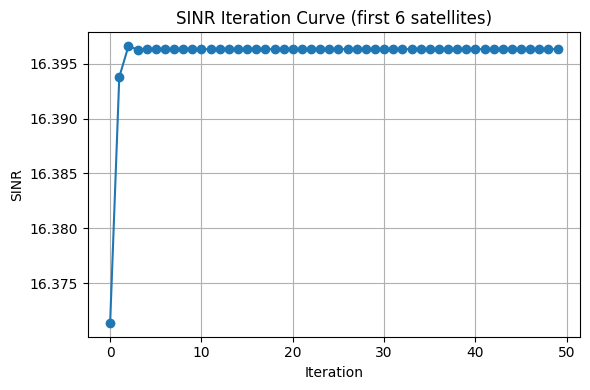

In [15]:

import matplotlib.pyplot as plt
k_to_plot = 6

if k_to_plot in sinr_itr_curves:
    plt.figure(figsize=(6, 4))
    plt.plot(sinr_itr_curves[k_to_plot], marker='o')
    plt.title(f"SINR Iteration Curve (first {k_to_plot} satellites)")
    plt.xlabel("Iteration")
    plt.ylabel("SINR")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"No curve found for k = {k_to_plot}")


I want to add that if the jammer and the desired source are within the diffraction limits of the receiver aperture, then we are in bigger trouble as you cannot use beamforming to null out the jammer. Then nonlinear subtraction methods may have to be used and that will hit the receiver sensitivity a lot I a sure. But without it there is no hope as both signal and jammer are smack on the beam.